In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from tqdm import tqdm
from collections import Counter
import warnings


df = pd.read_csv("SLS22.csv")
df

,id,location,month,year,comp,heat,run 1,run 2,trick 1,trick 2,trick 3,trick 4,trick 5,trick 6
0,Berer,jaksonville,7,2022,prelim men,1,5.0,1.1,7.0,0.0,7.6,0.0,NaN,NaN
1,Papa,jaksonville,7,2022,prelim men,1,3.7,7.0,7.2,0.0,8.4,8.2,NaN,NaN
2,Pudwill,jaksonville,7,2022,prelim men,1,2.0,1.3,0.0,0.0,0.0,0.0,NaN,NaN
3,Shirai,jaksonville,7,2022,prelim men,1,7.9,7.0,7.5,0.0,9.2,0.0,NaN,NaN
4,Mota,jaksonville,7,2022,prelim men,1,3.8,4.0,7.8,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Hoban,las_vegas,10,2022,final men,1,6.2,8.8,8.6,0.0,8.8,0.0,0.0,0.0
93,Hoefler,las_vegas,10,2022,final men,1,8.4,5.7,7.8,0.0,8.7,0.0,0.0,0.0
94,Eaton,las_vegas,10,2022,final men,1,6.9,7.2,0.0,8.4,7.5,0.0,NaN,NaN
95,Joslin,las_vegas,10,2022,final men,1,6.8,8.3,7.9,8.3,0.0,0.0,8.9,9.4


# **Uppgift 1**
## a)

In [3]:
#normalize the values of the trics and runs (deviding by 10)
df.iloc[:, 6:] = df.iloc[:, 6:].applymap(lambda x: x/10)

/var/folders/vh/hf3n9pw10qxb5_j0q5k1d5cr0000gn/T/ipykernel_53525/819013759.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 6:] = df.iloc[:, 6:].applymap(lambda x: x/10)


## b)

Vi ser att värdet 0 förekommer mycket oftare än de andra värdena. Sedan kan vi se att värden runt 0.8 också förekommer, medans alla andra värden mellan 0 och 0.6 nästan inte förekommer alls.

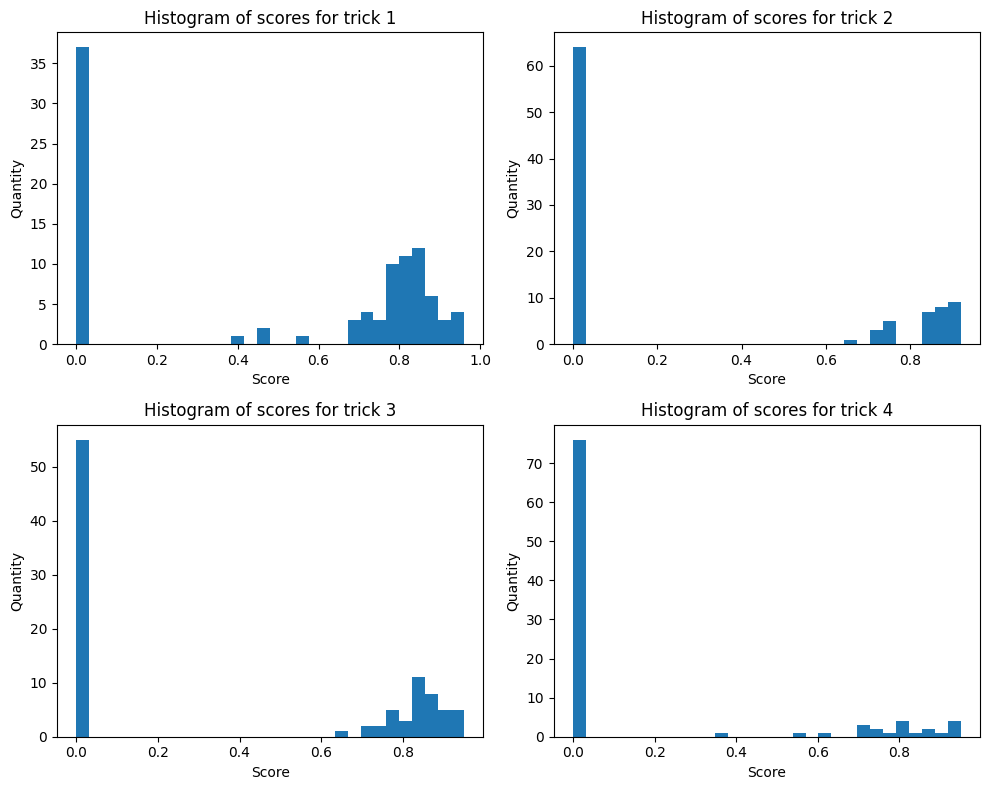

In [4]:
# get the partial dataframe with trick 1-4
xi_vec = df.iloc[:, 8:12]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

# plot all the trics separately
for i, column in enumerate(xi_vec.columns):
    axs[i].hist(xi_vec[column], bins=30)
    axs[i].set_xlabel('Score')
    axs[i].set_ylabel('Quantity')
    axs[i].set_title(f'Histogram of scores for {column}')

plt.tight_layout()
plt.show()

## c)

In [5]:
for i in range(1, 5):
    df[f"make {i}"] = (df[f"trick {i}"] > 0).astype(int)

## d)

Vi kan se att nästan alla trick som landas får en poäng över 0.6 vilket tyder på att observationerna i 1b) var korrekta och stämde överäns med datan vi nu fått.

In [6]:
#get all the skaters
unique_skaters = np.unique(df["id"].tolist(), axis = 0)

tricks_landed_counts = {}
tricks_over_06_score = {}

#calculate the number of tricks landed for each skater
for skater in unique_skaters:
    skater_df = df[df["id"] == skater]
    all_tricks = skater_df[skater_df.filter(like='make').eq(1).any(axis=1)]

    tricks_values = all_tricks.iloc[:, 8:12].values

    num_tricks_above_0 = np.sum(tricks_values > 0)
    num_tricks_above_06 = np.sum(tricks_values > 0.6)

    tricks_landed_counts[skater] = num_tricks_above_0
    tricks_over_06_score[skater] = num_tricks_above_06

df_odds = pd.DataFrame({
    'id': unique_skaters,
    'num_landed_tricks': tricks_landed_counts.values(),
    'num_landed_tricks_over_06': tricks_over_06_score.values()
})

df_odds['odds_of_score_over_06'] = np.where(df_odds['num_landed_tricks'] != 0,
                                            df_odds['num_landed_tricks_over_06'] / df_odds['num_landed_tricks'], 
                                            np.nan)

## e)

Eftersom alla punkter är ganksa jämnt utspidda med något fler på en rak linje kan man säga att det antingen inte finns någon korrelation alls eller en svag korrelatioin mellan båda runs.

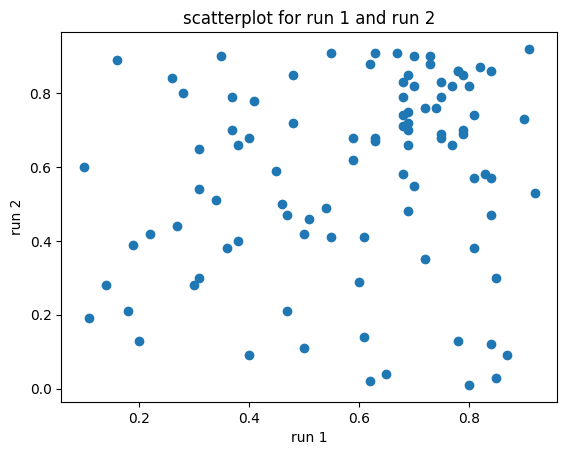

In [7]:
plt.scatter(df['run 1'], df['run 2'])
plt.xlabel('run 1')
plt.ylabel('run 2')
plt.title('scatterplot for run 1 and run 2')

plt.show()

# Uppgift 2
## a)

För varje skateboardåkare kan vi se till att vi använder momentmetoden, eller rättare sagt att vi sätter xMean lika med theta för varje åkare, eftersom alla är oberoende och likfördelade kommer detta att gå.

In [8]:
#create LCQ-dataframe
# List of specified contestents
specified_ids = ['Majerus', 'Oliveira', 'Decenzo', 'Santiago', 'Papa', 'Jordan', 'Ribeiro C',
                 'Eaton', 'Hoefler', 'O’neill', 'Mota', 'Shirai', 'Hoban', 'Gustavo',
                 'Foy', 'Midler']

df_lcq = df[df['id'].isin(specified_ids)]


In [9]:
df_LCQ_info= pd.DataFrame({
    'id': specified_ids,
})

In [10]:
theta_vec = {} 

#calculate the number of tricks that were not landed for each skater 
#and all the tricks that were performed
for skater in specified_ids:
    skater_df = df_lcq[df_lcq["id"] == skater]
    
    tricks_values = skater_df.iloc[:,14:].values

    #take away all the nan values
    cleaned_values = []

    for sublist in tricks_values:
        cleaned_sublist = [elem for elem in sublist if not np.isnan(elem)]
        cleaned_values.append(cleaned_sublist)
    
    tricks_values = np.concatenate(cleaned_values)

    num_tricks_equal_1 = np.sum(tricks_values == 1)
    num_tricks_performed = len(tricks_values)

    theta_vec[skater] = np.where(num_tricks_performed != 0, num_tricks_equal_1 / num_tricks_performed, np.nan)

df_theta = pd.DataFrame.from_dict(theta_vec, orient='index', columns=['Value']).reset_index()
df_theta.columns = ['Name', 'Value']

/var/folders/vh/hf3n9pw10qxb5_j0q5k1d5cr0000gn/T/ipykernel_53525/3692361086.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('RdYlGn')


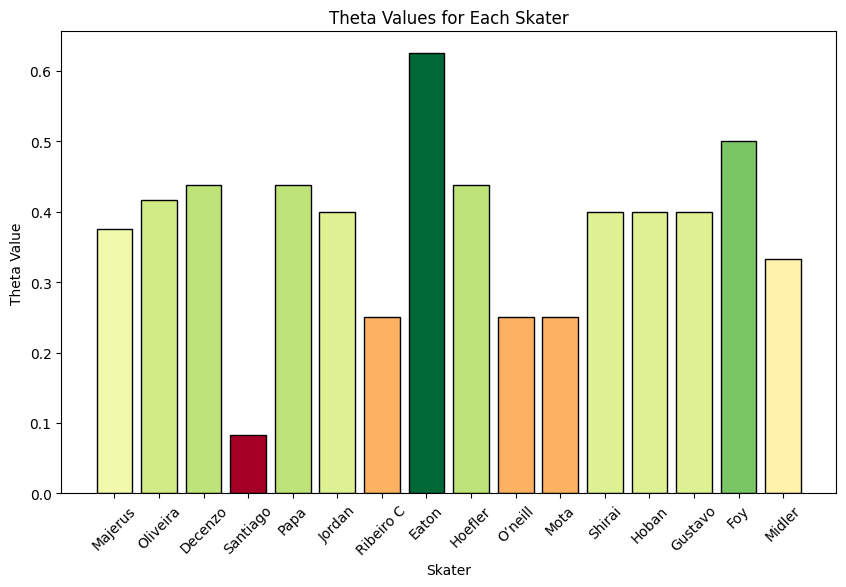

In [11]:
from matplotlib import cm

skaters = list(theta_vec.keys())
thetas = list(theta_vec.values())

# Create a colormap that transitions from red to green
colormap = cm.get_cmap('RdYlGn')

# Normalize the thetas to fit the colormap range
norm = plt.Normalize(min(thetas), max(thetas))

# Create a bar plot with color gradient
plt.figure(figsize=(10, 6))
bars = plt.bar(skaters, thetas, color=colormap(norm(thetas)), edgecolor='black')

plt.xlabel('Skater')
plt.ylabel('Theta Value')
plt.title('Theta Values for Each Skater')
plt.xticks(rotation=45)
plt.show()

## b)

Här använder vi momentametoden eftersom vi på liknande sätt vet att de är likfördelade och oberoende men samtidigt för att vi har två variabler alpha och beta som vi behöver få reda på.

In [12]:
def calc_X_distribution_momenta_metod(alpha_init = 1, beta_init = 1):
    
    # Initial guess for alpha and beta
    initial_guess = [alpha_init, beta_init]

    alpha_vals_tricks = {}
    beta_vals_tricks = {}

    for skater in specified_ids:
        skater_df = df_lcq[df_lcq["id"] == skater]
        
        tricks_values = skater_df.iloc[:,8:14].values

        #take away all the nan values
        cleaned_values = []

        for sublist in tricks_values:
            cleaned_sublist = [elem for elem in sublist if not np.isnan(elem)]
            cleaned_values.append(cleaned_sublist)
        
        tricks_values = np.concatenate(cleaned_values)

        m1 = sum(tricks_values)/len(tricks_values)
        m2 = sum(np.square(tricks_values))/len(tricks_values)

        def moments_equation(parameters):
            alpha, beta = parameters
            e1 = alpha / (alpha + beta)
            e2 = (alpha*beta)/((alpha+beta+1)*(alpha+beta)**2) + (alpha / (alpha + beta))**2
            return [e1 - m1, e2 - m2]
        
        # Use fsolve to find the values of alpha and beta
        alpha_estimate, beta_estimate = fsolve(moments_equation, initial_guess)

        alpha_vals_tricks[skater] = alpha_estimate
        beta_vals_tricks[skater] = beta_estimate

    df_LCQ_info["alpha_tricks"] = df_LCQ_info['id'].map(alpha_vals_tricks)
    df_LCQ_info["beta_tricks"] = df_LCQ_info['id'].map(beta_vals_tricks)


In [26]:
calc_X_distribution_momenta_metod()

Vi använder formeln explicita formeln från övning 11 och beräknar alpha och beta för respektive skater

In [45]:
alpha_vals_tricks = {}
beta_vals_tricks = {}

for skater in specified_ids:
    skater_df = df_lcq[df_lcq["id"] == skater]
    
    tricks_values = skater_df.iloc[:,8:14].values

    #take away all the nan values
    cleaned_values = []

    for sublist in tricks_values:
        cleaned_sublist = [elem for elem in sublist if not np.isnan(elem)]
        cleaned_values.append(cleaned_sublist)
    
    tricks_values = np.concatenate(cleaned_values)

    z_mean = np.mean(tricks_values)
    s2 = np.sum([(z - z_mean)**2 for z in tricks_values]) / len(tricks_values)

    # Use fsolve to find the values of alpha and beta
    alpha_estimate = ((z_mean * (1 - z_mean) / s2) - 1) * z_mean
    beta_estimate = ((z_mean * (1 - z_mean) / s2) - 1) * (1 - z_mean)

    alpha_vals_tricks[skater] = alpha_estimate
    beta_vals_tricks[skater] = beta_estimate

df_LCQ_info["alpha_tricks"] = df_LCQ_info['id'].map(alpha_vals_tricks)
df_LCQ_info["beta_tricks"] = df_LCQ_info['id'].map(beta_vals_tricks)

# c)

Vi kan anpassa en normalfördelning som modell för våra runs eftersom det är en vanligt använd fördelning. vi kan lösa ut modellen med hjälp av momentametoden som ovan då vi har två olika variabler.

# d)

Beräkna Y distributionen och X distributionen för olika optimala startvärden för alpha och beta för vardela betafördelning, sedanefter kolla att du får det optimalaste antalet förekomster av de riktiga vinnarna, vi ser att det blir något skummt med Eaton när hans vinsförekomster skall beräknas, det kan vara dålika parametrar på hans alpha och betavärden.

Annars förekommer 3 av de andra riktiga vinnarna med ungefärligen 85% sannolikhet.

In [14]:
# get all the beta and alpha values for the runs for each skater in the LCQ
def calc_Y_distribution_momenta_metod(alpha_init = 1, beta_init = 1):

    # Initial guess for alpha and beta
    initial_guess = [alpha_init, beta_init]

    alpha_vals_runs = {}
    beta_vals_runs = {}

    for skater in specified_ids:
        skater_df = df_lcq[df_lcq["id"] == skater]
        
        tricks_values = skater_df.iloc[:,6:8].values

        # take away all the nan values
        cleaned_values = []

        for sublist in tricks_values:
            cleaned_sublist = [elem for elem in sublist if not np.isnan(elem)]
            cleaned_values.append(cleaned_sublist)
        
        tricks_values = np.concatenate(cleaned_values)

        m1 = sum(tricks_values)/len(tricks_values)
        m2 = sum(np.square(tricks_values))/len(tricks_values)

        def moments_equation(parameters):
            alpha, beta = parameters
            e1 = alpha / (alpha + beta)
            e2 = (alpha*beta)/((alpha+beta+1)*(alpha+beta)**2) + (alpha / (alpha + beta))**2
            return [e1 - m1, e2 - m2]

        # Use fsolve to find the values of alpha and beta
        alpha_estimate, beta_estimate = fsolve(moments_equation, initial_guess)

        alpha_vals_runs[skater] = alpha_estimate
        beta_vals_runs[skater] = beta_estimate

    df_LCQ_info["alpha_runs"] = df_LCQ_info['id'].map(alpha_vals_runs)
    df_LCQ_info["beta_runs"] = df_LCQ_info['id'].map(beta_vals_runs)

In [15]:
calc_Y_distribution_momenta_metod()

In [48]:
alpha_vals_runs = {}
beta_vals_runs = {}

for skater in specified_ids:
    skater_df = df_lcq[df_lcq["id"] == skater]
    
    runs_values = skater_df.iloc[:,6:8].values

    #take away all the nan values
    cleaned_values = []

    for sublist in runs_values:
        cleaned_sublist = [elem for elem in sublist if not np.isnan(elem)]
        cleaned_values.append(cleaned_sublist)
    
    runs_values = np.concatenate(cleaned_values)

    z_mean = np.mean(tricks_values)
    s2 = np.sum([(z - z_mean)**2 for z in tricks_values]) / len(tricks_values)

    # Use fsolve to find the values of alpha and beta
    alpha_estimate = ((z_mean * (1 - z_mean) / s2) - 1) * z_mean
    beta_estimate = ((z_mean * (1 - z_mean) / s2) - 1) * (1 - z_mean)

    alpha_vals_runs[skater] = alpha_estimate
    beta_vals_runs[skater] = beta_estimate

df_LCQ_info["alpha_tricks"] = df_LCQ_info['id'].map(alpha_vals_runs)
df_LCQ_info["beta_tricks"] = df_LCQ_info['id'].map(beta_vals_runs)

In [16]:
W = []
W_scores = []

def LCQ_simulation(nr_sims = 5000, display_progress = False):
    if display_progress == True:
        sims = tqdm(range(nr_sims))
    else:
        sims = range(nr_sims)

    for i in sims:
        w = []
        LCQ_sim = {}

        for skater in specified_ids:
            skaterInfo = df_LCQ_info[df_LCQ_info['id'] == skater]

            alpha_runs = skaterInfo['alpha_runs']
            beta_runs = skaterInfo['beta_runs']

            alpha_tricks = skaterInfo['alpha_tricks']
            beta_tricks = skaterInfo['beta_runs']

            #calc tricks vals
            xi_vec = np.random.beta(alpha_tricks,beta_tricks, 4)
            thetai = theta_vec[skater]
            
            for index, xi in enumerate(xi_vec):
                vi = np.random.choice([0, 1], p=[1-thetai, thetai])
                xi_vec[index] = xi * vi
            
            xi_vec = sorted(xi_vec, reverse=True)
            highest_scores_tricks = xi_vec[:2]      

            #calc run vals
            runs_scores = np.random.beta(alpha_runs,beta_runs,2)

            skater_total_score = max(runs_scores) + sum(highest_scores_tricks)
            LCQ_sim[skater] = skater_total_score
        

        
        # Get the keys and values as tuples and sort by values in descending order
        sorted_sim_scores = sorted(LCQ_sim.items(), key=lambda x: x[1], reverse=True)

        # Get the top 4 items
        top_4_sim_scores = sorted_sim_scores[:4]

        # Separate the keys and values
        w, w_scores = zip(*top_4_sim_scores)

        W.append(tuple(sorted(w)))
        W_scores.append(w_scores)

In [17]:
def calc_total_odds_of_real_winners(W_data, modeling_sims = 5000):

    all_percentages = 0
    
    # write out the odds of each real winner to actually win
    real_winners = ['Gustavo', 'Hoban', 'Eaton', 'Decenzo']

    # Flatten the list of winners
    flattened_winners = [winner for sublist in W for winner in sublist]

    # Count the occurrences of each skateboarder
    winner_counts = Counter(flattened_winners)

    real_winner_counts = {winner: winner_counts[winner] for winner in real_winners}

    for winner, count in real_winner_counts.items():
        all_percentages += count*100/modeling_sims
    
    return all_percentages

Calculate the optimal alpha_trick and beta_trick for given alpha and beta runs to 1

In [42]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

highest_simulated_odds_of_real_winners = 0

best_alpha_trick_init = 1
best_beta_trick_init = 1

modeling_sims = 50

for alpha_trick in tqdm(range(1,100)):
    for beta_trick in tqdm(range(1,100)):
        try:
                
            W = []
            W_scores = []

            calc_X_distribution_momenta_metod(alpha_trick, beta_trick)

            LCQ_simulation(nr_sims = modeling_sims)

            odds_of_real_winners = calc_total_odds_of_real_winners(W, modeling_sims)

            if odds_of_real_winners > highest_simulated_odds_of_real_winners:
                highest_simulated_odds_of_real_winners = odds_of_real_winners
                
                best_alpha_trick_init = alpha_trick
                best_beta_trick_init = beta_trick     
        except:
            None
            
print(highest_simulated_odds_of_real_winners)

100%|██████████| 99/99 [12:43:21<00:00, 462.64s/it] 

298.0


In [20]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

best_alpha_run_init = 1
best_beta_run_init = 1

calc_X_distribution_momenta_metod(best_alpha_trick_init, best_beta_trick_init)

modeling_sims = 50

for alpha_run in tqdm(range(1,1)):
    for beta_run in range(1,1):
        try:

            W = []
            W_scores = []

            calc_Y_distribution_momenta_metod(alpha_run, beta_run)

            LCQ_simulation(nr_sims = modeling_sims)

            odds_of_real_winners = calc_total_odds_of_real_winners(W,modeling_sims)

            if odds_of_real_winners > highest_simulated_odds_of_real_winners:
                highest_simulated_odds_of_real_winners = odds_of_real_winners
                
                best_alpha_run_init = alpha_run
                best_beta_run_init = beta_run

        except:   
            None
            
print(highest_simulated_odds_of_real_winners)

0it [00:00, ?it/s]

0


Run the code for the optimal alpha and beta values that were calculated as the initials

In [49]:
W = []
W_scores = []
nr_sims = 5000

""" 
calc_X_distribution_momenta_metod(best_alpha_trick_init, best_beta_trick_init)
calc_Y_distribution_momenta_metod(best_alpha_run_init, best_beta_run_init) """

LCQ_simulation(nr_sims, display_progress = True)

#print(f"Tricks: alpha = {best_alpha_trick_init} beta = {best_beta_trick_init} \nRuns: alpha = {best_alpha_run_init} beta = {best_beta_run_init}")

""" Tricks: alpha = 13 beta = 56 
Runs: alpha = 1 beta = 1 """

100%|██████████| 5000/5000 [00:20<00:00, 246.27it/s]


' Tricks: alpha = 13 beta = 56 \nRuns: alpha = 1 beta = 1 '

In [50]:
##Get the mot common 4 winners as a group
# Flatten the list of lists into a single list
flattened_W = [tuple(sorted(sublist)) for sublist in W]

# Use Counter to count occurrences
counter = Counter(flattened_W)

# Define the real winners and sort them
real_winners = ['Gustavo', 'Hoban', 'Eaton', 'Decenzo']
real_winners.sort()

# Create the corresponding tuple
winners_tuple = tuple(real_winners)

# Count occurrences in the flattened_W list
occurrences = flattened_W.count(winners_tuple)

print(occurrences*100/nr_sims, "% the odds of all four of the real winners of coming up during the simulaitons")

# Flatten the list of winners
flattened_winners = [winner for sublist in W for winner in sublist]

# Count the occurrences of each skateboarder
winner_counts = Counter(flattened_winners)

real_winner_counts = {winner: winner_counts[winner] for winner in real_winners}

print("\n-- Odds of winning according to simulation --")

all_percentages = 0

for winner, count in real_winner_counts.items():
    print(f"{winner}: {count*100/nr_sims}%")
    all_percentages += count*100/nr_sims

print(all_percentages)

0.02 % the odds of all four of the real winners of coming up during the simulaitons

-- Odds of winning according to simulation --
Decenzo: 17.66%
Eaton: 3.16%
Gustavo: 49.12%
Hoban: 27.18%
97.12
